In [1]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import \
    get_base_prior_parameters, get_base_parameters, get_base_moment_parameters, set_moments, \
    LMMDataCache, CoordinateAscentUpdater, KLWrapper, MomentWrapper, ASISCoordinateAscent

from autograd import grad, hessian, jacobian, hessian_vector_product
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy as asp
import scipy as sp

import copy
from scipy import optimize

import time

In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

# Simulate data
N = 3     # observations per group
K = 1      # dimension of regressors
NG = 30      # number of groups

# Generate data
NObs = NG * N
true_beta = np.array(range(K))
true_beta = true_beta - np.mean(true_beta)
true_y_sd = 1.0
true_y_info = 1 / true_y_sd**2

true_mu = 1.0
true_mu_sd = 20.0
true_mu_info = 1 / true_mu_sd**2
true_u_sufficient = np.random.normal(true_mu, 1 / np.sqrt(true_mu_info), NG)
true_u_ancillary = true_u_sufficient - true_mu

x_mat = np.random.random(K * NObs).reshape(NObs, K) - 0.5
x_rot = np.full((K, K), 0.5)
for k in range(K):
    x_rot[k, k] = 1.0
x_mat = np.matmul(x_mat, x_rot)

y_g_vec = np.array([ g for g in range(NG) for n in range(N) ])
true_mean = np.matmul(x_mat, true_beta) + true_u_sufficient[y_g_vec]
y_vec = np.random.normal(true_mean, 1 / np.sqrt(true_y_info), NG * N)

print N * NG

90


In [3]:
# Whether or not you are optimizing a sufficient or ancillary model.
# Expect sufficient to be good when true_mu_sd >> true_y_sd
# Expect ancillary to be good when true_mu_sd << true_y_sd
sufficient = False

prior_par = get_base_prior_parameters(K)
lmm_par = get_base_parameters(K, NG, sufficient=sufficient)
moment_par = get_base_moment_parameters(K, NG, sufficient=sufficient)
data_cache = LMMDataCache(x_mat, y_vec, y_g_vec)

set_moments(lmm_par, moment_par)
init_moment_par = copy.deepcopy(moment_par)
init_par_vec = lmm_par.get_free()

moment_indices = copy.deepcopy(moment_par)
moment_indices.set_vector(np.array(range(moment_indices.vector_size())))

In [4]:
asis_updater = ASISCoordinateAscent(moment_par, data_cache, prior_par)

asis_time = time.time()
tol = 1e-9
delta = float('inf')
i = 0
max_iters = 5000
while delta > tol and i < max_iters:
    i += 1
    delta = asis_updater.update()
    if i % 5 == 0:
        print 'Iter %d, delta %f' % (i, delta)

if i < max_iters:
    asis_time = time.time() - asis_time
else:
    print 'ASIS did not converge.'
    asis_time = float('inf')

asis_moment_par_opt = copy.deepcopy(asis_updater.ca_updater_sufficient.moment_par)

print 'ASIS ascent time (in seconds): %f, iters: %d' % (asis_time, i)


Iter 5, delta 0.000000
ASIS ascent time (in seconds): 0.180841, iters: 6


In [5]:
# Perform coordinate ascent.
asis_init = False
if asis_init:
    if sufficient:
        ca_updater = CoordinateAscentUpdater(
            asis_updater.ca_updater_sufficient.moment_par, data_cache, prior_par, sufficient=sufficient)
    else:
        ca_updater = CoordinateAscentUpdater(
            asis_updater.ca_updater_ancillary.moment_par, data_cache, prior_par, sufficient=sufficient)
else:
    ca_updater = CoordinateAscentUpdater(init_moment_par, data_cache, prior_par, sufficient=sufficient)

ca_time = time.time()
tol = 1e-9
delta = float('inf')
i = 0
max_iters = 5000
while delta > tol and i < max_iters:
    i += 1
    delta = ca_updater.update()
    if i % 5 == 0:
        print 'Iter %d, delta %f' % (i, delta)

if i < max_iters:
    ca_time = time.time() - ca_time
else:
    print 'Coordinate ascent did not converge.'
    ca_time = float('inf')

ca_moment_par_opt = copy.deepcopy(ca_updater.moment_par)

print 'Coordinate ascent time (in seconds): %f, iters: %d' % (ca_time, i)

Iter 5, delta 1.077073
Iter 10, delta 1.337108
Iter 15, delta 1.736408
Iter 20, delta 2.389815
Iter 25, delta 3.562472
Iter 30, delta 5.980906
Iter 35, delta 12.253634
Iter 40, delta 37.646164
Iter 45, delta 368.049207
Iter 50, delta 329.773079
Iter 55, delta 1.629165
Iter 60, delta 0.259312
Iter 65, delta 0.249823
Iter 70, delta 0.242745
Iter 75, delta 0.235880
Iter 80, delta 0.229209
Iter 85, delta 0.222726
Iter 90, delta 0.216427
Iter 95, delta 0.210306
Iter 100, delta 0.204358
Iter 105, delta 0.198579
Iter 110, delta 0.192962
Iter 115, delta 0.187505
Iter 120, delta 0.182202
Iter 125, delta 0.177049
Iter 130, delta 0.172042
Iter 135, delta 0.167177
Iter 140, delta 0.162449
Iter 145, delta 0.157855
Iter 150, delta 0.153391
Iter 155, delta 0.149053
Iter 160, delta 0.144837
Iter 165, delta 0.140741
Iter 170, delta 0.136761
Iter 175, delta 0.132894
Iter 180, delta 0.129135
Iter 185, delta 0.125483
Iter 190, delta 0.121935
Iter 195, delta 0.118486
Iter 200, delta 0.115136
Iter 205, delt

Iter 1625, delta 0.000032
Iter 1630, delta 0.000032
Iter 1635, delta 0.000031
Iter 1640, delta 0.000030
Iter 1645, delta 0.000029
Iter 1650, delta 0.000028
Iter 1655, delta 0.000027
Iter 1660, delta 0.000027
Iter 1665, delta 0.000026
Iter 1670, delta 0.000025
Iter 1675, delta 0.000024
Iter 1680, delta 0.000024
Iter 1685, delta 0.000023
Iter 1690, delta 0.000022
Iter 1695, delta 0.000022
Iter 1700, delta 0.000021
Iter 1705, delta 0.000020
Iter 1710, delta 0.000020
Iter 1715, delta 0.000019
Iter 1720, delta 0.000019
Iter 1725, delta 0.000018
Iter 1730, delta 0.000018
Iter 1735, delta 0.000017
Iter 1740, delta 0.000017
Iter 1745, delta 0.000016
Iter 1750, delta 0.000016
Iter 1755, delta 0.000015
Iter 1760, delta 0.000015
Iter 1765, delta 0.000015
Iter 1770, delta 0.000014
Iter 1775, delta 0.000014
Iter 1780, delta 0.000013
Iter 1785, delta 0.000013
Iter 1790, delta 0.000013
Iter 1795, delta 0.000012
Iter 1800, delta 0.000012
Iter 1805, delta 0.000012
Iter 1810, delta 0.000011
Iter 1815, d

Iter 3215, delta 0.000000
Iter 3220, delta 0.000000
Iter 3225, delta 0.000000
Iter 3230, delta 0.000000
Iter 3235, delta 0.000000
Iter 3240, delta 0.000000
Iter 3245, delta 0.000000
Iter 3250, delta 0.000000
Iter 3255, delta 0.000000
Iter 3260, delta 0.000000
Iter 3265, delta 0.000000
Iter 3270, delta 0.000000
Iter 3275, delta 0.000000
Iter 3280, delta 0.000000
Iter 3285, delta 0.000000
Iter 3290, delta 0.000000
Iter 3295, delta 0.000000
Iter 3300, delta 0.000000
Iter 3305, delta 0.000000
Iter 3310, delta 0.000000
Iter 3315, delta 0.000000
Iter 3320, delta 0.000000
Iter 3325, delta 0.000000
Iter 3330, delta 0.000000
Iter 3335, delta 0.000000
Iter 3340, delta 0.000000
Iter 3345, delta 0.000000
Iter 3350, delta 0.000000
Iter 3355, delta 0.000000
Iter 3360, delta 0.000000
Iter 3365, delta 0.000000
Iter 3370, delta 0.000000
Iter 3375, delta 0.000000
Iter 3380, delta 0.000000
Iter 3385, delta 0.000000
Iter 3390, delta 0.000000
Iter 3395, delta 0.000000
Iter 3400, delta 0.000000
Iter 3405, d

In [20]:
kl_wrapper = KLWrapper(lmm_par, moment_par, prior_par, x_mat, y_vec, y_g_vec, sufficient=sufficient)
print kl_wrapper.kl(init_par_vec)

import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.kl(init_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: kl_wrapper.kl_grad(init_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: kl_wrapper.kl_hvp(init_par_vec, init_par_vec + 1), number=time_num) / time_num

# Optimize.
vb_time = time.time()

# Note: to intialize the trust region with ASIS you'd have to get the natural parameters out of the moments.

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 500, 'disp': True, 'gtol': 1e-9 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

print sufficient
print 'trust region time (in seconds): %f' %  vb_time
print 'trust optimum: %f' %  kl_wrapper.kl(vb_opt.x)

AssertionError: 

False

In [ ]:
# Optimize.
vb_time = time.time()

# Note: to intialize the trust region with ASIS you'd have to get the natural parameters out of the moments.

print 'Running Newton Trust Region'
trust_init = copy.deepcopy(init_par_vec)
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.kl(par, verbose=True),
    trust_init, method='trust-ncg', jac=kl_wrapper.kl_grad, hessp=kl_wrapper.kl_hvp,
    tol=1e-6, options={'maxiter': 500, 'disp': True, 'gtol': 1e-9 })

vb_time = time.time() - vb_time

lmm_par_opt = copy.deepcopy(lmm_par)
lmm_par_opt.set_free(vb_opt.x)

moment_par_opt = copy.deepcopy(moment_par)
set_moments(lmm_par_opt, moment_par_opt)

print 'trust region time (in seconds): %f' %  vb_time

In [8]:
# Make sure the coordinate ascent and trust region are close
moment_diff = np.sum(np.abs(ca_moment_par_opt.get_vector() - moment_par_opt.get_vector()))
moment_diff_asis = np.sum(np.abs(ca_moment_par_opt.get_vector() - asis_moment_par_opt.get_vector()))

print kl_wrapper.kl(vb_opt.x)

print 'total moment difference (ca vs asis): %f' % moment_diff_asis
print 'total moment difference (ca vs tr): %f' % moment_diff
print 'trust region seconds: %f' % vb_time
print 'coordinate ascent seconds: %f' % ca_time
print 'asis ascent seconds: %f' % asis_time

113.203269911
total moment difference (ca vs asis): 7571.943813
total moment difference (ca vs tr): 0.000000
trust region seconds: 7.918562
coordinate ascent seconds: 19.008029
asis ascent seconds: 0.180841


In [9]:
from VariationalBayes.Models.LinearMixedModel.ConjugateModel import get_elbo_model_term, get_entropy_from_moments
    
ca_entropy = get_entropy_from_moments(ca_moment_par_opt, lmm_par_guess=lmm_par_opt)
asis_entropy = get_entropy_from_moments(asis_moment_par_opt, lmm_par_guess=lmm_par_opt)

# Compare the optima found:
print '\nValues of the ELBO.  Larger is better.'
print 'Coordinate ascent: %f' % (ca_entropy + get_elbo_model_term(data_cache, ca_moment_par_opt, prior_par, sufficient=sufficient))
print 'Trust region: %f ' % -kl_wrapper.kl(vb_opt.x)
print 'ASIS: %f' % (asis_entropy + get_elbo_model_term(data_cache, asis_moment_par_opt, prior_par, sufficient=True)[0])


-0.297550983299
-0.297550983299
-5.41275062066
-5.41275062066
-5.96522093036
-0.297550983299
4.33383738969
-5.41275062066

Values of the ELBO.  Larger is better.
Coordinate ascent: -113.203270
Trust region: -113.203270 
ASIS: -279.654203


--------------- beta:

[ 0.]
[-0.5303859]
--------------- mu:

0.0840089385059
1.0
--------------- mu info:

0.0043016873547
0.0025
--------------- y info:

1.21577736502
1.0


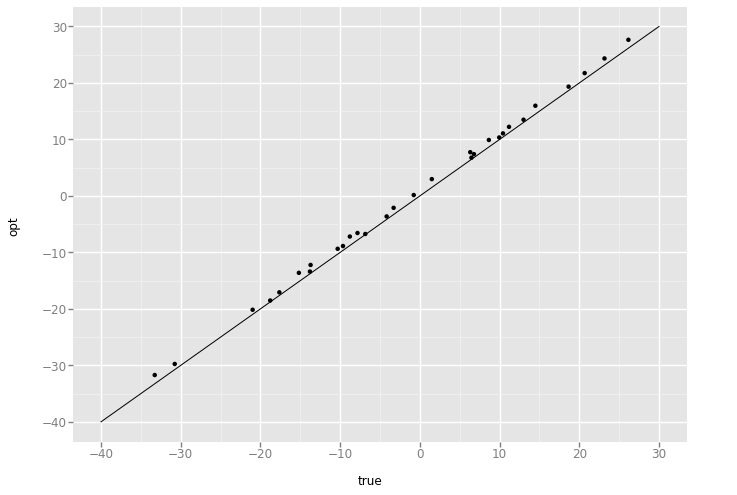

<ggplot: (8730149113901)>


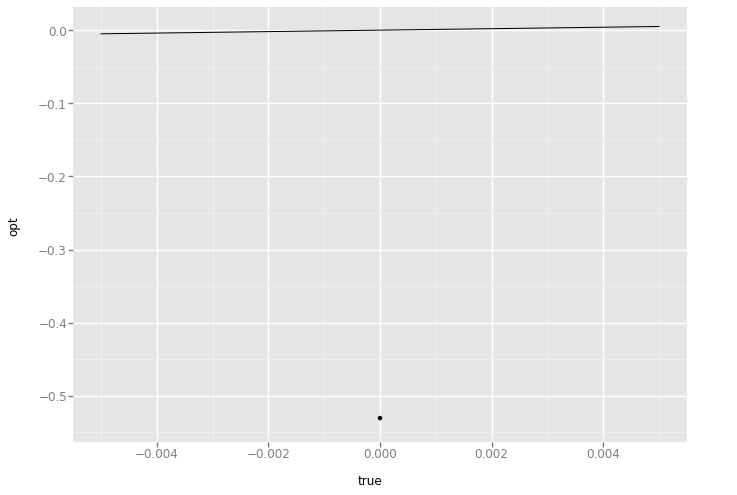

<ggplot: (8730149103993)>


In [10]:
# Compare TR to the truth.

print '--------------- beta:\n'
print true_beta
print lmm_par_opt['beta'].e()

print '--------------- mu:\n'
print lmm_par_opt['mu'].e()[0]
print true_mu

print '--------------- mu info:\n'
print lmm_par_opt['mu_info'].e()[0]
print true_mu_info

print '--------------- y info:\n'
print lmm_par_opt['y_info'].e()[0]
print true_y_info

from ggplot import *
import pandas as pd
%matplotlib inline

if sufficient:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_sufficient })
else:
    plot_df = pd.DataFrame({ 'opt': lmm_par_opt['u'].e(), 'true': true_u_ancillary })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'opt': lmm_par_opt['beta'].e(), 'true': true_beta })
print ggplot(plot_df, aes(x='true', y='opt')) + geom_point() + geom_abline(slope=1, intercept=0)


--------------- mu:

0.0840089387187
[ 0.08400894]
--------------- mu info:

0.0043016873547
[ 0.00430169]
--------------- y info:

1.21577736502
[ 1.21577737]


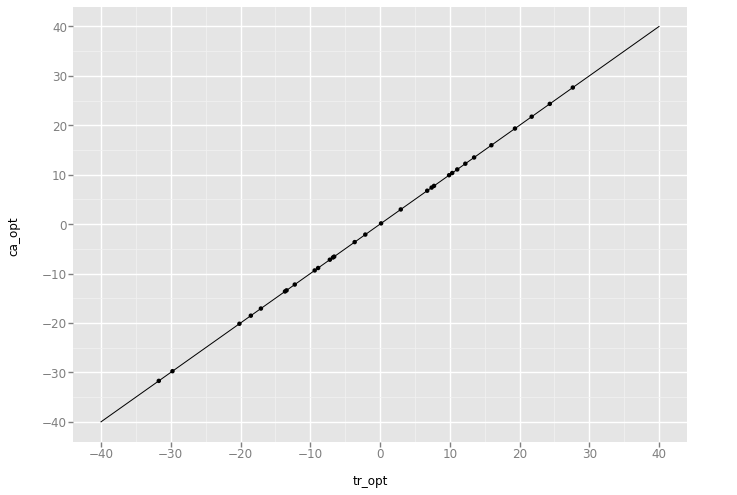

<ggplot: (8730148650989)>


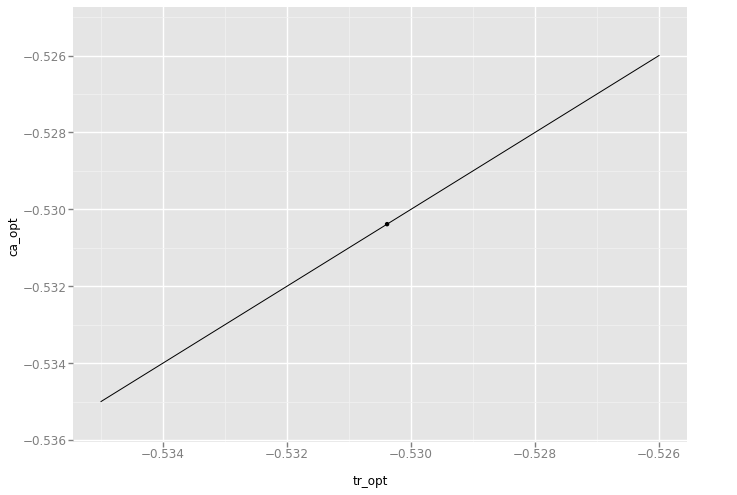

<ggplot: (8730148500069)>


In [11]:
# Compare coordinate ascent to TR

print '--------------- mu:\n'
print ca_moment_par_opt['e_mu'].get()
print moment_par_opt['e_mu'].get()

print '--------------- mu info:\n'
print ca_moment_par_opt['e_mu_info'].get()
print moment_par_opt['e_mu_info'].get()

print '--------------- y info:\n'
print ca_moment_par_opt['e_y_info'].get()
print moment_par_opt['e_y_info'].get()


plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_u'].get(), 'ca_opt': ca_moment_par_opt['e_u'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta'].get(), 'ca_opt': ca_moment_par_opt['e_beta'].get() })
print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


--------------- beta:

[-0.5303859]
[-0.35833408]
--------------- mu:

[ 0.08400894]
[ 0.17825569]
--------------- mu info:

[ 0.00430169]
[ 73.54078021]
--------------- y info:

[ 1.21577737]
[ 0.00420162]


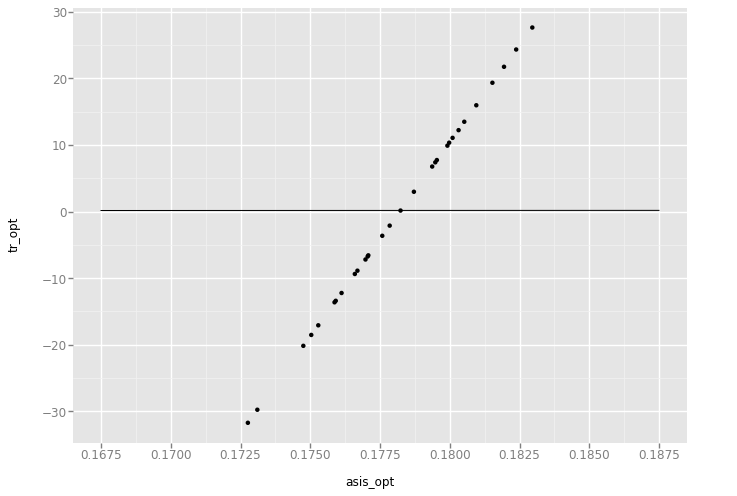

<ggplot: (8730148371221)>


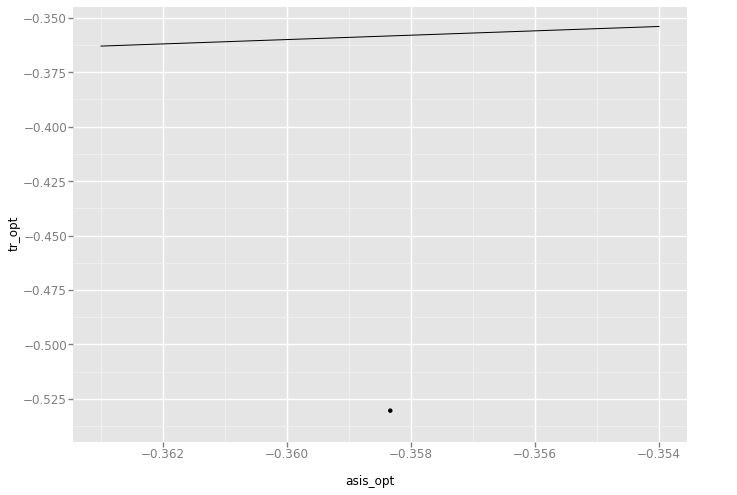

<ggplot: (8730149056345)>


In [12]:
# Compare trust region to asis

print '--------------- beta:\n'
print moment_par_opt['e_beta'].get()
print asis_moment_par_opt['e_beta'].get()

print '--------------- mu:\n'
print moment_par_opt['e_mu'].get()
print asis_moment_par_opt['e_mu'].get()

print '--------------- mu info:\n'
print moment_par_opt['e_mu_info'].get()
print asis_moment_par_opt['e_mu_info'].get()

print '--------------- y info:\n'
print moment_par_opt['e_y_info'].get()
print asis_moment_par_opt['e_y_info'].get()


plot_df = pd.DataFrame({ 'asis_opt': asis_moment_par_opt['e_u'].get(), 'tr_opt': moment_par_opt['e_u'].get() })
print ggplot(plot_df, aes(x='asis_opt', y='tr_opt')) + geom_point() + geom_abline(slope=1, intercept=0)

plot_df = pd.DataFrame({ 'asis_opt': asis_moment_par_opt['e_beta'].get(), 'tr_opt': moment_par_opt['e_beta'].get() })
print ggplot(plot_df, aes(x='asis_opt', y='tr_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


In [13]:
# Check differences if any

print moment_par_opt['e_mu_info']
print ca_moment_par_opt['e_mu_info']

print moment_par_opt['e_log_mu_info']
print ca_moment_par_opt['e_log_mu_info']

diffs = moment_par_opt.get_vector() - ca_moment_par_opt.get_vector()
print np.where(np.abs(diffs) > 1e-3)
print moment_indices

# plot_df = pd.DataFrame({ 'tr_opt': moment_par_opt['e_beta_outer'].get(), 'ca_opt': ca_moment_par_opt['e_beta_outer'].get() })
# print ggplot(plot_df, aes(x='tr_opt', y='ca_opt')) + geom_point() + geom_abline(slope=1, intercept=0)


e_mu_info: [ 0.00430169]
e_mu_info: 0.0043016873547
e_log_mu_info: [-5.48200319]
e_log_mu_info: -5.48200319414
(array([], dtype=int64),)
Moment Parameters:
	e_beta:
[0]
	e_beta_outer:
[[ 1.]]
	e_mu: [2]
	e_mu2: [3]
	e_mu_info: [4]
	e_log_mu_info: [5]
	e_y_info: [6]
	e_log_y_info: [7]
	e_u:
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37]
	e_u2:
[38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67]


In [14]:
# # Slow, but probably faster than using CG if you want the covariance of many parameters.
# hess_time = time.time()
# print 'Calculating KL Hessian...'
# kl_hess = kl_wrapper.kl_hess(vb_opt.x)
# hess_time =  time.time() - hess_time
# elbo_hess = -kl_hess
# print 'Done.'

# print 'Hessian time (seconds): %f' % hess_time

In [15]:
# hess_norm = np.sqrt(np.sum(kl_hess**2))
# diag_norm = np.sqrt(np.sum(np.diag(kl_hess)**2))

# # How diagonal is the Hessian?
# print 'Proportion of the frobenius norm off the diagonal:'
# print (hess_norm - diag_norm) / hess_norm